In [4]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
import numpy as np
from scipy.stats import entropy

In [2]:
categories = ['rec.motorcycles', 'rec.sport.baseball',
                'comp.graphics', 'sci.space',
                'talk.politics.mideast']
remove = ("headers", "footers", "quotes")
ng5_train = fetch_20newsgroups(subset='train', categories=categories, remove=remove)
ng5_test = fetch_20newsgroups(subset='test', categories=categories, remove=remove)

## Exploring Data

In [4]:
print("\n".join(ng5_train.data[0].split("\n")))


I'd be willing to make two wagers:
1) Snow doesn't win ROY.
2) Mattingly is out of baseball within five years.

I'm skeptical of the first, because I don't think Snow is that good a
player, and he is on a losing team.

I'm skeptical of the second because of his back.  Mattingly is 32 this
year, and how many players play until they are 40?  Not too many, and
most of them didn't have chronic back problems when they were 32.

Could be wrong on either or both, but I think that's the smart way to
bet...


In [5]:
print(ng5_train.target_names[ng5_train.target[0]])

rec.sport.baseball


## Third step : Select n samples from non labeled data U

In [313]:
## Create a pipeline to make it simpler
from sklearn.pipeline import Pipeline
text_clf = Pipeline([
     ('vect', CountVectorizer()),
     ('tfidf', TfidfTransformer()),
     ('clf', MultinomialNB()),
     #('clf', SGDClassifier(loss='log', penalty='l2',
      #                     alpha=1e-3,random_state=42,
       #                    max_iter=5, tol=None)),
])

# Start the loop process

In [239]:
from sklearn.utils import Bunch

length = len(ng5_train.data)
seed_uncert = seed_margin = seed_entropy = Bunch(data=ng5_train.data[0:1500], target=ng5_train.target[0:1500])
unlabeled_uncert = unlabeled_margin = unlabeled_entropy = Bunch(data=ng5_train.data[1500:length-1], target=ng5_train.target[1500:length-1])

In [240]:
# Define function which updates datasets
def update(seed, unlabeled, ind):
     seed.data = seed.data + [unlabeled.data[i] for i in ind]
     seed.target = np.append(seed.target,unlabeled.target[ind])
     unlabeled.data = [unlabeled.data[i] for i in range(len(unlabeled.data)) if i not in ind]
     unlabeled.target = np.delete(unlabeled.target, ind)
     return seed, unlabeled

In [241]:
def update_accuracy(seed, unlabeled, accuracy):
     global text_clf, ng5_test
     # Train the clasifier
     text_clf.fit(seed.data, seed.target)
     # predicted classes and corresponding probabilities
     predicted_proba = text_clf.predict_proba(unlabeled.data)
     # check the real accuracy on test data
     predicted = text_clf.predict(ng5_test.data)
     accuracy.append(np.mean(predicted == ng5_test.target))
     return accuracy, predicted_proba 

In [312]:
#import copy
# number of samples
#from random import sample
n = 500

length = len(ng5_train.data)
seed_uncert = Bunch(data=ng5_train.data[0:n], target=ng5_train.target[0:n])
seed_margin = Bunch(data=ng5_train.data[0:n], target=ng5_train.target[0:n])
seed_entropy = Bunch(data=ng5_train.data[0:n], target=ng5_train.target[0:n])
seed_rand = Bunch(data=ng5_train.data[0:n], target=ng5_train.target[0:n])
unlabeled_uncert = Bunch(data=ng5_train.data[n:length-1], target=ng5_train.target[n:length-1])
unlabeled_margin = Bunch(data=ng5_train.data[n:length-1], target=ng5_train.target[n:length-1])
unlabeled_entropy = Bunch(data=ng5_train.data[n:length-1], target=ng5_train.target[n:length-1])
unlabeled_rand = Bunch(data=ng5_train.data[n:length-1], target=ng5_train.target[n:length-1])

accuracy_uncert, accuracy_margin, accuracy_entropy, accuracy_rand = [], [], [], []

n=80

# Start the loop
while len(unlabeled_uncert.data) > 0:
     ## Least Confidence (aka. Uncertainty) Strategy
     accuracy_uncert, predicted_proba = update_accuracy(seed_uncert, unlabeled_uncert, accuracy_uncert)
     uncertainty = 1 - predicted_proba.max(axis=1)
     ## Margin Sampling
     accuracy_margin, predicted_proba = update_accuracy(seed_margin, unlabeled_margin, accuracy_margin)
     part = np.partition(-predicted_proba, 1, axis=1)
     margin = - part[:, 0] + part[:, 1]
     ## Entropy based
     accuracy_entropy, predicted_proba = update_accuracy(seed_entropy, unlabeled_entropy, accuracy_entropy)
     entr = entropy(predicted_proba.T)
     ## Random
     accuracy_rand, predicted_proba = update_accuracy(seed_rand, unlabeled_rand, accuracy_rand)
    
     if len(unlabeled_uncert.data) > n : 
          # index of top n uncertainty score
          ind_uncert = np.argpartition(uncertainty, -n)[-n:]
          # index of n min margin score
          ind_margin = np.argpartition(margin, n)[:n]
          # index of top n entropy score
          ind_entropy = np.argpartition(entr, -n)[-n:]
          # ind random
          ind_rand = sample([i for i in range(len(unlabeled_rand.data)-1)], n)
            
          seed_uncert, unlabeled_uncert = update(seed_uncert, unlabeled_uncert, ind_uncert)
          seed_margin, unlabeled_margin = update(seed_margin, unlabeled_margin, ind_margin)
          seed_entropy, unlabeled_entropy = update(seed_entropy, unlabeled_entropy, ind_entropy)
          seed_rand, unlabeled_rand = update(seed_rand, unlabeled_rand, ind_rand)

     else :
          # seed.data = seed.data + unlabeled.data
          # seed.target = np.append(seed.target, unlabeled.target)
          # text_clf.fit(seed.data, seed.target)
          unlabeled_uncert.data = unlabeled_margin = unlabeled_entropy = unlabeled_rand = []

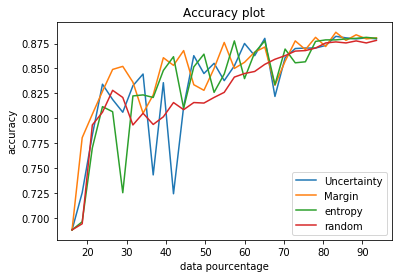

In [230]:
#from matplotlib.pyplot import *
#from numpy import linspace

x = linspace(500, 2900, len(accuracy_uncert))
plot(x/len(accuracy_uncert), accuracy_uncert)
plot(x/len(accuracy_uncert), accuracy_margin)
plot(x/len(accuracy_uncert), accuracy_entropy)
plot(x/len(accuracy_uncert), accuracy_rand)

xlabel('data pourcentage')
ylabel('accuracy')
legend(['Uncertainty','Margin','entropy', 'random'])
title('Accuracy plot')
show()

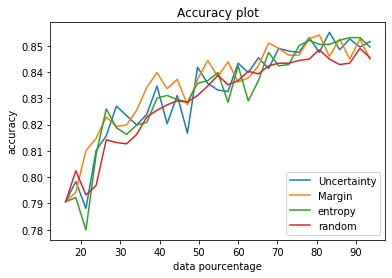

In [247]:
#from matplotlib.pyplot import *
#from numpy import linspace

x = linspace(500, 2900, len(accuracy_uncert))
plot(x/len(accuracy_uncert), accuracy_uncert)
plot(x/len(accuracy_uncert), accuracy_margin)
plot(x/len(accuracy_uncert), accuracy_entropy)
plot(x/len(accuracy_uncert), accuracy_rand)

xlabel('data pourcentage')
ylabel('accuracy')
legend(['Uncertainty','Margin','entropy', 'random'])
title('Accuracy plot')
show()

In [213]:
len(unlabeled_rand.data)

135

# Test with another Dataset

In [1]:
import pandas as pd 
# Read data from file 'filename.csv' 
# (in the same directory that your python process is based)
# Control delimiters, rows, column names with read_csv (see later) 
data = pd.read_csv("corpus_categorias_treino.csv", sep=',', engine='python')

In [2]:
data = data[['words','category']]
data.head()

,words,category
0,He certainly didn't want a wife who was fickle...,adventure
1,"If he had married her , he'd have been asking ...",adventure
2,Sometimes he woke up in the middle of the nigh...,adventure
3,His plans and dreams had revolved around her s...,adventure
4,The best antidote for the bitterness and disap...,adventure


In [5]:
msk = np.random.rand(len(data)) < 0.8
train = data[msk]
test = data[~msk]

In [6]:
## Create a pipeline to make it simpler
from sklearn.pipeline import Pipeline
text_clf = Pipeline([
     ('vect', CountVectorizer()),
     ('tfidf', TfidfTransformer()),
     ('clf', MultinomialNB()),
     #('clf', SGDClassifier(loss='log', penalty='l2',
      #                     alpha=1e-3,random_state=42,
       #                    max_iter=5, tol=None)),
])